In [1]:
!pip install yfinance

In [2]:
! pip install packages vectorbt

In [3]:
!pip install bt

# **Coin Selection**

In [4]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import yfinance as yf
import numpy as np
import bt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve
)

In [5]:
# URL of CoinMarketCap historical snapshot for January 3, 2021
url = 'https://coinmarketcap.com/historical/20210103/'

# Get HTML content
headers = {'User-Agent': 'Mozilla/5.0'}
response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.text, 'html.parser')

# Extract coin rows
rows = soup.find_all('tr')
data = []

# Exclude symbols
excluded_symbols = {'BTC', 'ETH', 'USDT', 'USDC', 'WBTC'}

for row in rows[1:]:
    cols = row.find_all('td')
    if len(cols) > 4:
        name = cols[1].get_text(strip=True)
        symbol = cols[2].get_text(strip=True)
        price_text = cols[3].get_text(strip=True).replace('$', '').replace(',', '')
        try:
            price = float(price_text)
        except:
            continue
        if symbol not in excluded_symbols:
            data.append({'name': name, 'symbol': symbol, 'price': price})

# Convert to DataFrame and sort
df = pd.DataFrame(data)
df_sorted = df.sort_values(by='price', ascending=False).reset_index(drop=True)

# Show top 10 highest-priced coins in 2021 (excluding specified coins)
print(df_sorted.head(10))


              name symbol         price
0      LTCLitecoin    LTC  1.061010e+10
1           XRPXRP    XRP  1.025442e+10
2      DOTPolkadot    DOT  8.995148e+09
3  BCHBitcoin Cash    BCH  7.845655e+09
4       ADACardano    ADA  6.377915e+09
5  BNBBinance Coin    BNB  5.942183e+09
6    LINKChainlink   LINK  5.453374e+09
7    BSVBitcoin SV    BSV  3.190474e+09
8       XLMStellar    XLM  2.989656e+09
9           EOSEOS    EOS  2.625024e+09


# **Taringing & Testing Split BB vs BITW**

## **Parameter Selection**

In [6]:
# === Parameters ===
coins = {
    'LTC-USD': 'Litecoin', 'XRP-USD': 'XRP', 'DOT-USD': 'Polkadot',
    'BCH-USD': 'Bitcoin Cash', 'ADA-USD': 'Cardano', 'BNB-USD': 'Binance Coin',
    'LINK-USD': 'Chainlink', 'BSV-USD': 'Bitcoin SV', 'XLM-USD': 'Stellar', 'EOS-USD': 'EOS'
}
tickers = list(coins.keys())
start_train = '2021-01-01'
end_train = '2024-02-12'

# === Download Data ===
price_data = yf.download(tickers, start=start_train, end=end_train)['Close']
price_data.columns = [col.replace('-USD', '') for col in price_data.columns]
price_data.dropna(how='all', axis=1, inplace=True)

# === Define Parameter Ranges ===
window_range = [15, 20, 25, 30]
num_std_range = [1.5, 2.0, 2.5]
threshold_range = [0.005, 0.01, 0.015]

# === Optimization Loop ===
results = []

for coin in price_data.columns:
    coin_prices = price_data[[coin]].dropna()
    for window in window_range:
        for num_std in num_std_range:
            for threshold in threshold_range:
                sma = coin_prices[coin].rolling(window=window).mean()
                std = coin_prices[coin].rolling(window=window).std()
                lower_band = sma - num_std * std

                signal = (coin_prices[coin] < lower_band).astype(float)
                weights = signal.ffill().fillna(0)
                weights[weights < threshold] = 0

                weights_df = pd.DataFrame(0.0, index=coin_prices.index, columns=[coin])
                weights_df.loc[weights.index, coin] = weights.values

                strategy = bt.Strategy(f"{coin}_{window}_{num_std}_{threshold}", [
                    bt.algos.RunDaily(),
                    bt.algos.SelectThese([coin]),
                    bt.algos.WeighTarget(weights_df),
                    bt.algos.Rebalance()
                ])
                backtest = bt.Backtest(strategy, coin_prices)
                result = bt.run(backtest)[0]
                stats = result.stats

                results.append({
                    'Coin': coin,
                    'Window': window,
                    'Num_STD': num_std,
                    'Threshold': threshold,
                    'CAGR': stats.loc['cagr'],
                    'Sharpe': stats.loc['daily_sharpe'],
                    'Sortino': stats.loc['daily_sortino'],
                    'Max_Drawdown': stats.loc['max_drawdown']
                })

# === Create and Filter Best by Coin ===
results_df = pd.DataFrame(results)

# Select best row per coin by highest CAGR
best_by_coin = results_df.sort_values(by='CAGR', ascending=False).groupby('Coin').first().reset_index()

# Show results
print(best_by_coin)


/tmp/ipython-input-6-1414568968.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  price_data = yf.download(tickers, start=start_train, end=end_train)['Close']
[*********************100%***********************]  10 of 10 completed
100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

   Coin  Window  Num_STD  Threshold      CAGR    Sharpe   Sortino  \
0   ADA      20      1.5      0.010  0.225157  0.627206  1.047087   
1   BCH      25      1.5      0.010  0.185062  0.514024  0.827846   
2   BNB      15      2.5      0.005  0.151805  0.860130  2.553798   
3   BSV      15      2.0      0.005  0.369597  0.854800  2.051936   
4   DOT      30      1.5      0.005  0.237861  0.582014  0.902216   
5   EOS      20      1.5      0.005  0.178681  0.498708  0.813109   
6  LINK      30      1.5      0.015  0.271671  0.651792  1.094484   
7   LTC      25      1.5      0.005  0.049751  0.261746  0.380692   
8   XLM      20      2.0      0.005  0.337199  0.972885  1.956549   
9   XRP      30      2.0      0.010  0.213668  0.648606  1.148781   

   Max_Drawdown  
0     -0.367151  
1     -0.472380  
2     -0.086384  
3     -0.177490  
4     -0.496530  
5     -0.471679  
6     -0.398274  
7     -0.410282  
8     -0.171039  
9     -0.179846  


## **BB Training Set**

/tmp/ipython-input-7-4098530025.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  price_data = yf.download(tickers, start=start_train, end=end_train)['Close']
[*********************100%***********************]  10 of 10 completed
/tmp/ipython-input-7-4098530025.py:49: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bitw_df = yf.download("BITW", start=start_train, end=end_train)[['Close']].dropna()
[*********************100%***********************]  1 of 1 completed
100%|██████████| 11/11 [00:15<00:00,  1.40s/it]


                      CAGR    Sharpe   Sortino  Max_Drawdown
Coin                                                        
ADA               0.067191  0.378380  0.597104     -0.246782
BCH               0.185951  0.661151  0.914288     -0.472380
BNB               0.152524  1.038300  3.082899     -0.086384
BSV               0.371501  1.079093  2.589098     -0.153573
DOT               0.143023  0.537815  0.772674     -0.496530
EOS               0.255857  0.845881  1.242551     -0.373591
LINK              0.227111  0.761690  1.150984     -0.398274
LTC               0.049976  0.321367  0.421681     -0.410282
XLM               0.065357  0.435147  0.679736     -0.163290
XRP               0.163497  0.737144  1.217638     -0.191385
BITW (Benchmark) -0.226478  0.110155  0.193295     -0.963820


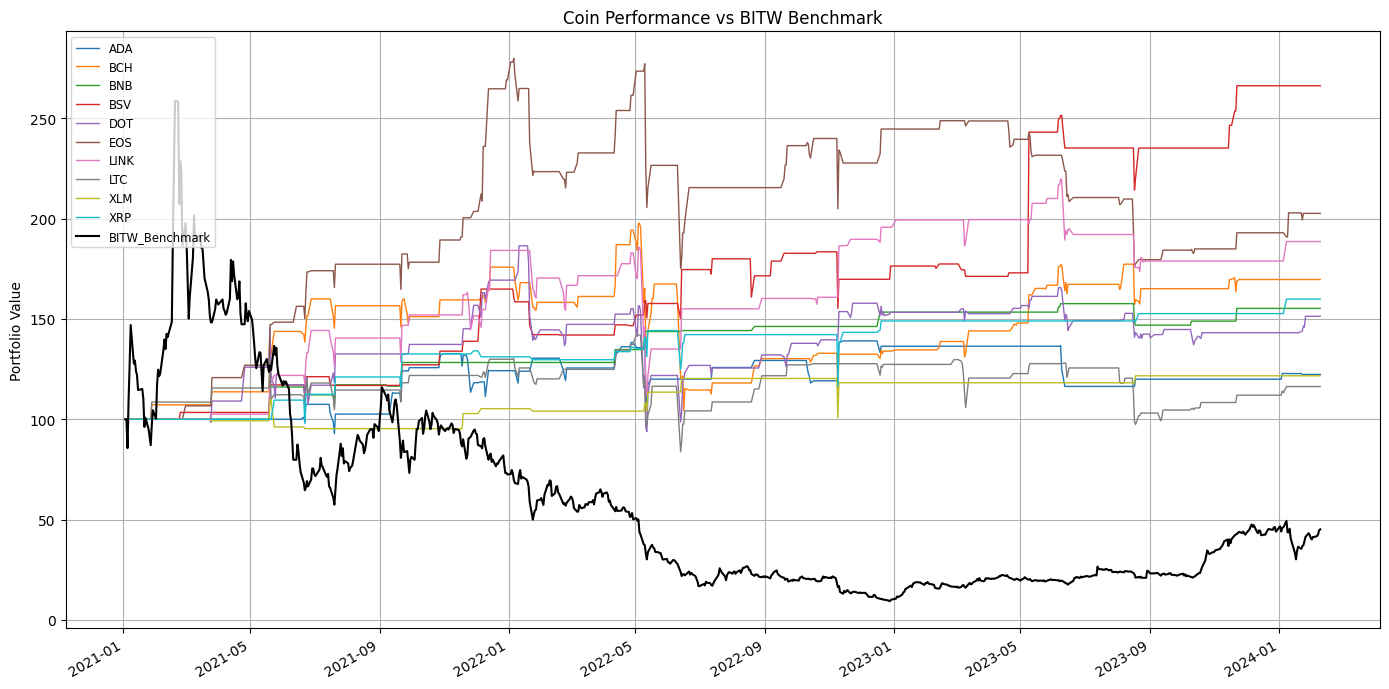

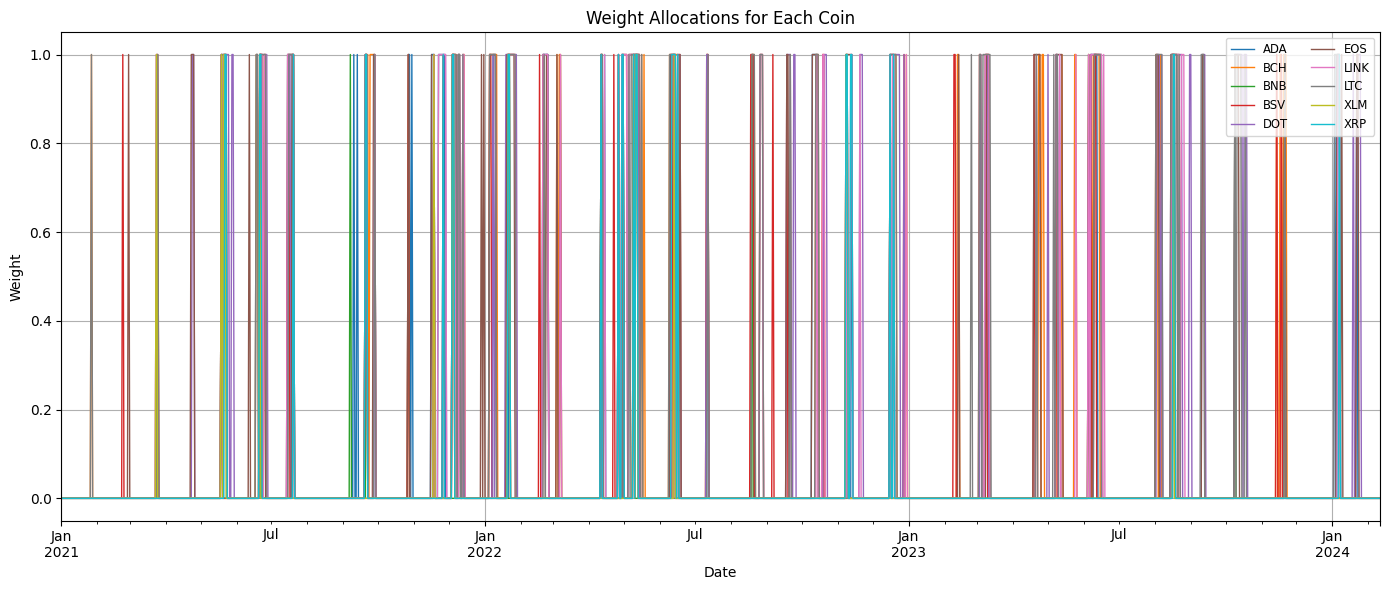

In [7]:
# === Optimized Parameters ===
optimized_params = {
    'ADA': (20, 1.5, 0.010),
    'BCH': (25, 1.5, 0.010),
    'BNB': (15, 2.5, 0.005),
    'BSV': (15, 2.0, 0.005),
    'DOT': (30, 1.5, 0.005),
    'EOS': (20, 1.5, 0.005),
    'LINK': (30, 1.5, 0.015),
    'LTC': (25, 1.5, 0.005),
    'XLM': (20, 2.0, 0.005),
    'XRP': (30, 2.0, 0.010)
}

# === Training Dates ===
start_train = '2021-01-01'
end_train = '2024-02-12'

# === Download Prices ===
tickers = [f"{coin}-USD" for coin in optimized_params.keys()]
price_data = yf.download(tickers, start=start_train, end=end_train)['Close']
price_data.columns = [col.replace('-USD', '') for col in price_data.columns]

# === Backtest Strategies ===
strategies = []
weights_dict = {}
for coin, (window, num_std, threshold) in optimized_params.items():
    prices = price_data[[coin]].dropna()
    sma = prices[coin].rolling(window).mean()
    std = prices[coin].rolling(window).std()
    lower_band = sma - num_std * std

    signal = (prices[coin] < (lower_band - threshold)).astype(float)
    weights = signal.ffill().fillna(0)

    weights_df = pd.DataFrame(0.0, index=prices.index, columns=[coin])
    weights_df.loc[weights.index, coin] = weights.values
    weights_dict[coin] = weights_df

    strat = bt.Strategy(f"{coin}_BB", [
        bt.algos.RunDaily(),
        bt.algos.SelectThese([coin]),
        bt.algos.WeighTarget(weights_df),
        bt.algos.Rebalance()
    ])
    strategies.append(bt.Backtest(strat, prices))

# === Benchmark ===
bitw_df = yf.download("BITW", start=start_train, end=end_train)[['Close']].dropna()
bitw_df.columns = ['BITW']
benchmark = bt.Strategy('BITW_Benchmark', [
    bt.algos.RunMonthly(),
    bt.algos.SelectAll(),
    bt.algos.WeighEqually(),
    bt.algos.Rebalance()
])
benchmark_bt = bt.Backtest(benchmark, bitw_df)

# === Run Backtests ===
results = bt.run(*strategies, benchmark_bt)

# === Extract Stats ===
summary = []
for name in results.keys():
    stats = results[name].stats
    summary.append({
        'Coin': name.replace('_BB', '') if name != 'BITW_Benchmark' else 'BITW (Benchmark)',
        'CAGR': stats.loc['cagr'],
        'Sharpe': stats.loc['daily_sharpe'],
        'Sortino': stats.loc['daily_sortino'],
        'Max_Drawdown': stats.loc['max_drawdown']
    })
df_summary = pd.DataFrame(summary).set_index('Coin')
print(df_summary)

# === Plot Equity Curve ===
plt.figure(figsize=(14, 7))
for name in results.keys():
    color = 'black' if name == 'BITW_Benchmark' else None
    results[name].prices.plot(label=name.replace('_BB', ''), linewidth=1.5 if name == 'BITW_Benchmark' else 1, color=color)
plt.title('Coin Performance vs BITW Benchmark')
plt.ylabel('Portfolio Value')
plt.grid(True)
plt.legend(loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

# === Plot Weights ===
weights_all = pd.concat(weights_dict.values(), axis=1)
weights_all.plot(figsize=(14, 6), linewidth=1)
plt.title('Weight Allocations for Each Coin')
plt.ylabel('Weight')
plt.xlabel('Date')
plt.grid(True)
plt.legend(loc='upper right', fontsize='small', ncol=2)
plt.tight_layout()
plt.show()


## **BB Testing Set**

/tmp/ipython-input-8-4108563932.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_test, end=end_test)['Close']
[*********************100%***********************]  10 of 10 completed
/tmp/ipython-input-8-4108563932.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bitw = yf.download("BITW", start=start_test, end=end_test)['Close'].dropna()
[*********************100%***********************]  1 of 1 completed
100%|██████████| 11/11 [00:05<00:00,  1.86it/s]


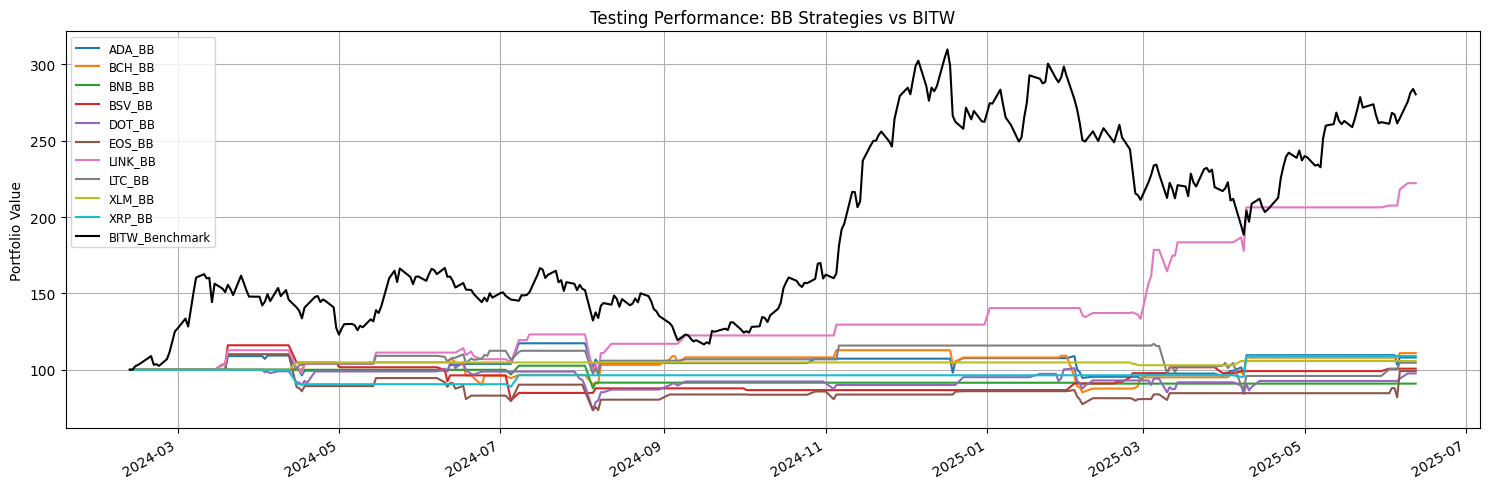

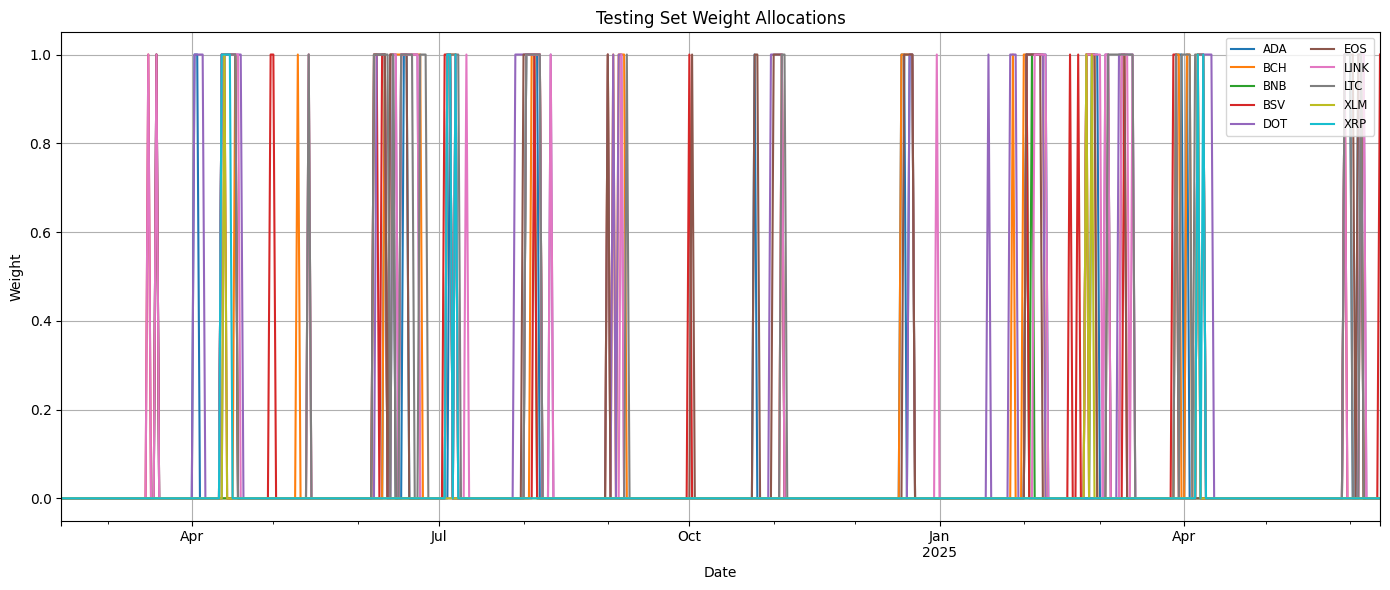


=== Testing Strategy Performance ===
                    CAGR  Sharpe  Sortino  Max Drawdown
Coin                                                   
ADA                 5.99    0.35     0.52        -20.21
BCH                 8.09    0.42     0.63        -24.38
BNB                -6.89   -0.42    -0.47        -14.42
BSV                 0.55    0.15     0.19        -31.14
DOT                -1.82    0.10     0.14        -29.85
EOS                -0.65    0.17     0.26        -33.33
LINK               82.22    1.68     3.03        -20.41
LTC                 3.45    0.27     0.34        -25.46
XLM                 4.29    0.89     4.07         -1.73
XRP                 6.74    0.47     0.96        -11.12
BITW (Benchmark)  117.05    1.65     3.17        -39.19


In [8]:
# === Optimized Parameters from Training ===

# === Testing Period ===
start_test = '2024-02-13'
end_test = '2025-06-13'

# === Download Prices ===
tickers = [coin + '-USD' for coin in optimized_params.keys()]
data = yf.download(tickers, start=start_test, end=end_test)['Close']
data.columns = [col.replace('-USD', '') for col in data.columns]
data.dropna(how='all', axis=1, inplace=True)

# === Download Benchmark ===
bitw = yf.download("BITW", start=start_test, end=end_test)['Close'].dropna()
bitw_df = pd.DataFrame(bitw)
bitw_df.columns = ['BITW']

# === Strategy and Benchmark Setup ===
backtests = []
weights_dict = {}

for coin, (window, num_std, threshold) in optimized_params.items():
    price = data[[coin]].dropna()
    sma = price[coin].rolling(window).mean()
    std = price[coin].rolling(window).std()
    lower_band = sma - num_std * std

    signal = (price[coin] < (lower_band - threshold)).astype(float)
    weights = signal.ffill().fillna(0)

    weights_df = pd.DataFrame(0.0, index=price.index, columns=[coin])
    weights_df.loc[weights.index, coin] = weights.values

    weights_dict[coin] = weights_df.copy()

    strat = bt.Strategy(f'{coin}_BB', [
        bt.algos.RunDaily(),
        bt.algos.SelectThese([coin]),
        bt.algos.WeighTarget(weights_df),
        bt.algos.Rebalance()
    ])
    backtests.append(bt.Backtest(strat, price))

# === Benchmark Backtest ===
benchmark = bt.Strategy('BITW_Benchmark', [
    bt.algos.RunMonthly(),
    bt.algos.SelectAll(),
    bt.algos.WeighEqually(),
    bt.algos.Rebalance()
])
benchmark_test = bt.Backtest(benchmark, bitw_df)

# === Run All Tests ===
results = bt.run(*backtests, benchmark_test)

# === Plot: Performance ===
plt.figure(figsize=(14, 6))
for name in results.keys():
    color = 'black' if name == 'BITW_Benchmark' else None
    results[name].plot(label=name, color=color)
plt.title('Testing Performance: BB Strategies vs BITW')
plt.ylabel('Portfolio Value')
plt.grid(True)
plt.legend(loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

# === Plot: Weight Allocations ===
weights_all = pd.DataFrame(index=data.index)
for coin, wdf in weights_dict.items():
    weights_all[coin] = wdf[coin]
plt.figure(figsize=(14, 6))
weights_all.plot(ax=plt.gca())
plt.title('Testing Set Weight Allocations')
plt.ylabel('Weight')
plt.xlabel('Date')
plt.grid(True)
plt.legend(loc='upper right', fontsize='small', ncol=2)
plt.tight_layout()
plt.show()

# === Summary Stats ===
summary = []
for name in results.keys():
    stats = results[name].stats
    label = name.replace('_BB', '') if name != 'BITW_Benchmark' else 'BITW (Benchmark)'
    summary.append({
        'Coin': label,
        'CAGR': round(stats.loc['cagr'] * 100, 2),
        'Sharpe': round(stats.loc['daily_sharpe'], 2),
        'Sortino': round(stats.loc['daily_sortino'], 2),
        'Max Drawdown': round(stats.loc['max_drawdown'] * 100, 2)
    })

df_summary = pd.DataFrame(summary).set_index('Coin')
print("\n=== Testing Strategy Performance ===")
print(df_summary)


# **BB + EMA (BE) Testing Split**

## **BE Parameter Selection**

In [9]:
import bt

# === Setup ===
coins = {
    'ADA': 'Cardano', 'BCH': 'Bitcoin Cash', 'BNB': 'Binance Coin',
    'BSV': 'Bitcoin SV', 'DOT': 'Polkadot', 'EOS': 'EOS',
    'LINK': 'Chainlink', 'LTC': 'Litecoin', 'XLM': 'Stellar', 'XRP': 'XRP'
}

start_train = '2021-01-01'
end_train = '2024-02-12'

# === Download price data ===
tickers = [f"{coin}-USD" for coin in coins.keys()]
price_data = yf.download(tickers, start=start_train, end=end_train)['Close']
price_data.columns = [col.replace('-USD', '') for col in price_data.columns]
price_data.dropna(axis=1, how='any', inplace=True)

# === Parameter Ranges ===
window_range = [15, 20, 25]
std_range = [1.5, 2.0, 2.5]
threshold_range = [0.005, 0.01, 0.015]
ema_short_range = [10]
ema_long_range = [30, 50]

# === Grid Search ===
results = []

for coin in price_data.columns:
    prices = price_data[[coin]].dropna()
    for window in window_range:
        for std in std_range:
            for threshold in threshold_range:
                for ema_short in ema_short_range:
                    for ema_long in ema_long_range:
                        sma = prices[coin].rolling(window).mean()
                        std_dev = prices[coin].rolling(window).std()
                        lower_band = sma - std * std_dev
                        ema_fast = prices[coin].ewm(span=ema_short, adjust=False).mean()
                        ema_slow = prices[coin].ewm(span=ema_long, adjust=False).mean()

                        bb_signal = (prices[coin] < (lower_band - threshold)).astype(float)
                        ema_signal = (ema_fast > ema_slow).astype(float)
                        combined_signal = ((bb_signal + ema_signal) >= 1).astype(float)

                        weights = combined_signal.ffill().fillna(0)
                        weights_df = pd.DataFrame(0.0, index=prices.index, columns=[coin])
                        weights_df.loc[weights.index, coin] = weights.values

                        strategy = bt.Strategy(f"{coin}_BBEMA",
                                               [bt.algos.RunDaily(),
                                                bt.algos.SelectThese([coin]),
                                                bt.algos.WeighTarget(weights_df),
                                                bt.algos.Rebalance()])
                        backtest = bt.Backtest(strategy, prices)
                        result = bt.run(backtest)[0]
                        stats = result.stats

                        results.append({
                            'Coin': coin,
                            'BB_Window': window,
                            'STD': std,
                            'Threshold': threshold,
                            'EMA_Short': ema_short,
                            'EMA_Long': ema_long,
                            'CAGR': stats.loc['cagr'],
                            'Sharpe': stats.loc['daily_sharpe'],
                            'Sortino': stats.loc['daily_sortino'],
                            'Max_Drawdown': stats.loc['max_drawdown']
                        })

results_df = pd.DataFrame(results)
best_params = results_df.sort_values(by='CAGR', ascending=False).groupby('Coin').first().reset_index()
best_params


/tmp/ipython-input-9-2443472049.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  price_data = yf.download(tickers, start=start_train, end=end_train)['Close']
[*********************100%***********************]  10 of 10 completed
100%|██████████| 1/1 [00:01<00:00,  1.54s/it]


,Coin,BB_Window,STD,Threshold,EMA_Short,EMA_Long,CAGR,Sharpe,Sortino,Max_Drawdown
0,ADA,20,2.0,0.010,10,50,1.811678,1.411287,2.721393,-0.425998
1,BCH,25,1.5,0.005,10,30,0.173752,0.499467,0.873904,-0.705511
2,BNB,15,2.5,0.015,10,30,1.835401,1.372067,2.778045,-0.498248
3,BSV,15,2.0,0.015,10,30,0.212599,0.516884,1.021776,-0.614025
4,DOT,25,2.5,0.010,10,30,0.771494,0.910811,1.640253,-0.554177
5,EOS,20,1.5,0.010,10,50,0.170566,0.514496,0.843430,-0.745016
6,LINK,20,2.0,0.005,10,30,0.443660,0.714332,1.169729,-0.708614
7,LTC,25,1.5,0.010,10,30,-0.029889,0.294286,0.448788,-0.683886
8,XLM,20,1.5,0.005,10,30,0.632801,0.786152,1.559713,-0.496155
9,XRP,25,2.0,0.010,10,30,0.421669,0.677003,1.233815,-0.624247


## **BE Training Set**

/tmp/ipython-input-10-19615992.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  price_data = yf.download(tickers, start=start_train, end=end_train)['Close']
[*********************100%***********************]  10 of 10 completed
/tmp/ipython-input-10-19615992.py:54: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bitw_df = yf.download("BITW", start=start_train, end=end_train)[['Close']].dropna()
[*********************100%***********************]  1 of 1 completed
100%|██████████| 11/11 [00:15<00:00,  1.42s/it]


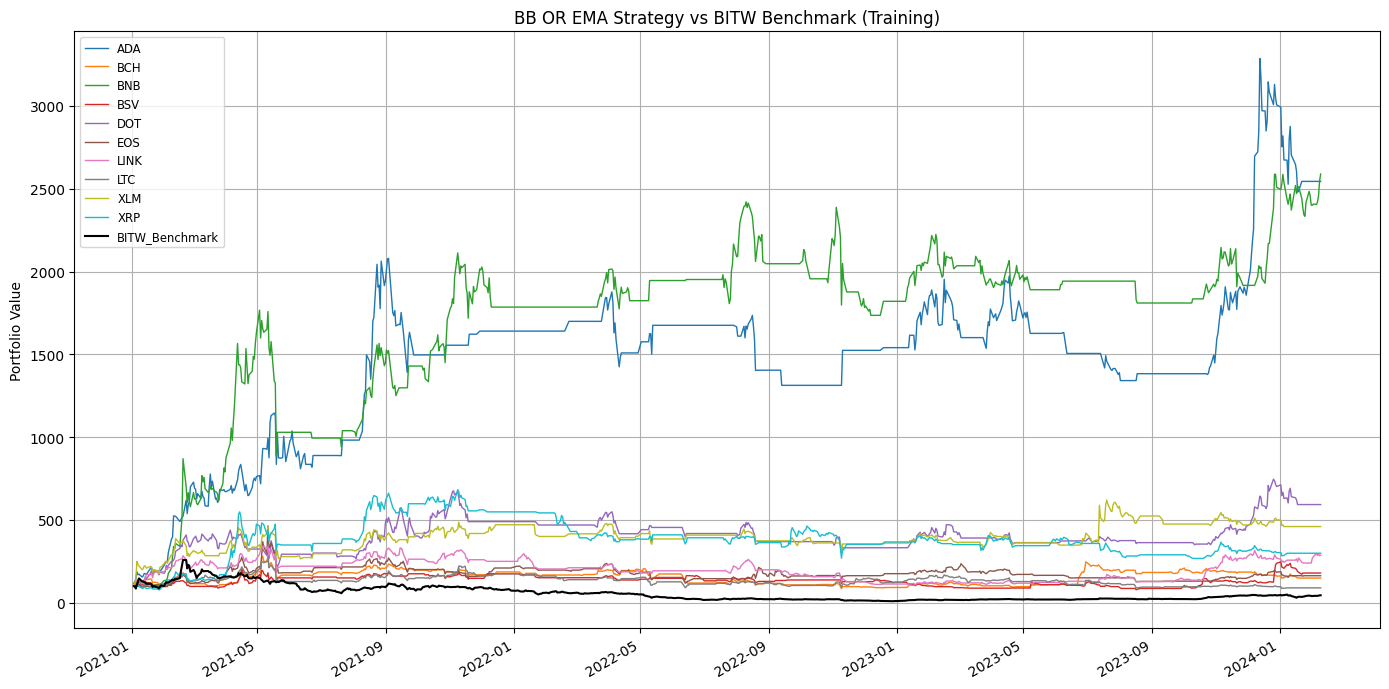

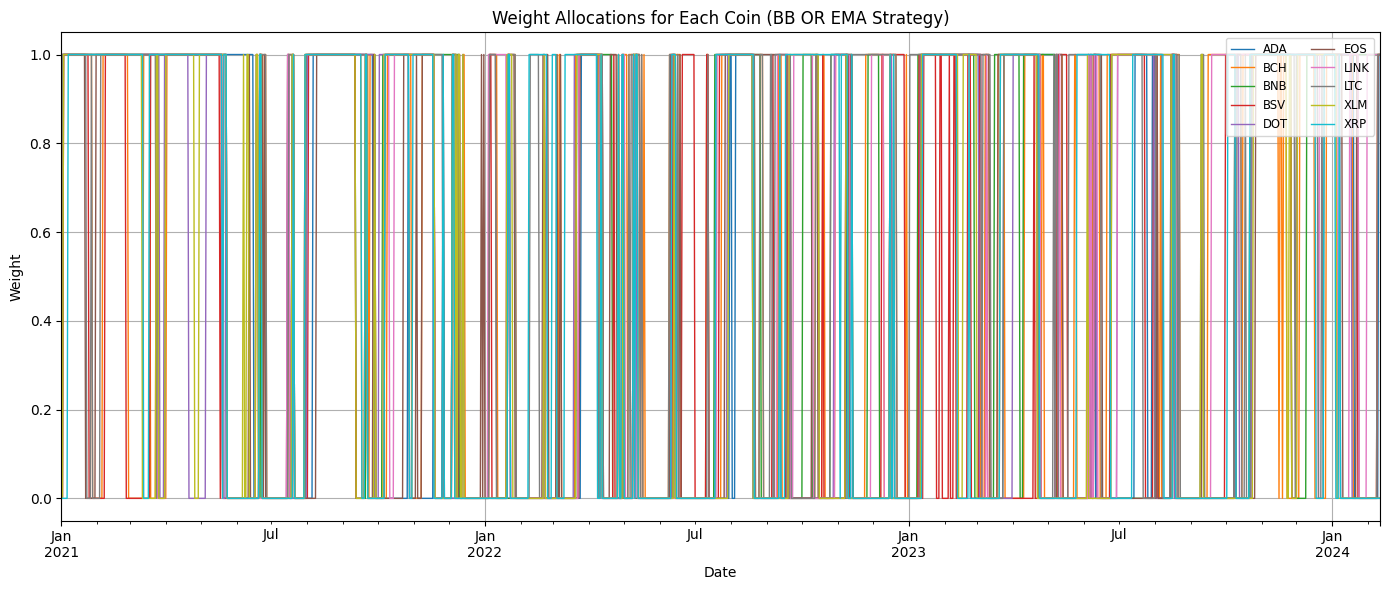

                      CAGR    Sharpe   Sortino  Max_Drawdown
Coin                                                        
ADA               1.711891  1.677975  3.232317     -0.368719
BCH               0.075526  0.484364  0.802008     -0.705511
BNB               1.790448  1.638942  3.467438     -0.498248
BSV               0.207345  0.609394  1.125780     -0.613668
DOT               0.727513  1.080554  1.907586     -0.554177
EOS               0.171380  0.607431  0.999672     -0.745016
LINK              0.357041  0.783753  1.278860     -0.683513
LTC              -0.081471  0.261759  0.379552     -0.671035
XLM               0.636341  0.950666  1.933084     -0.427069
XRP               0.423880  0.814018  1.515160     -0.608123
BITW (Benchmark) -0.226478  0.110155  0.193295     -0.963820


In [10]:
# === Optimized Parameters ===
optimized_params_or_strategy = {
    'ADA': (20, 2.0, 0.010, 10, 50),
    'BCH': (25, 1.5, 0.005, 10, 30),
    'BNB': (15, 2.5, 0.015, 10, 30),
    'BSV': (15, 2.0, 0.015, 10, 30),
    'DOT': (25, 2.5, 0.010, 10, 30),
    'EOS': (20, 1.5, 0.010, 10, 50),
    'LINK': (20, 2.0, 0.005, 10, 30),
    'LTC': (25, 1.5, 0.010, 10, 30),
    'XLM': (20, 1.5, 0.005, 10, 30),
    'XRP': (25, 2.0, 0.010, 10, 30)
}

start_train = '2021-01-01'
end_train = '2024-02-12'
tickers = [f"{coin}-USD" for coin in optimized_params_or_strategy]

# === Download Data ===
price_data = yf.download(tickers, start=start_train, end=end_train)['Close']
price_data.columns = [col.replace('-USD', '') for col in price_data.columns]
price_data.dropna(axis=1, inplace=True)

# === Build Backtests and Store Weights ===
strategies = []
weights_dict = {}

for coin, (bb_window, std, threshold, ema_short, ema_long) in optimized_params_or_strategy.items():
    prices = price_data[[coin]].dropna()
    sma = prices[coin].rolling(bb_window).mean()
    std_dev = prices[coin].rolling(bb_window).std()
    lower_band = sma - std * std_dev
    ema_fast = prices[coin].ewm(span=ema_short, adjust=False).mean()
    ema_slow = prices[coin].ewm(span=ema_long, adjust=False).mean()

    bb_signal = (prices[coin] < (lower_band - threshold)).astype(float)
    ema_signal = (ema_fast > ema_slow).astype(float)
    combined_signal = ((bb_signal + ema_signal) >= 1).astype(float)

    weights = combined_signal.ffill().fillna(0)
    weights_df = pd.DataFrame(0.0, index=prices.index, columns=[coin])
    weights_df.loc[weights.index, coin] = weights.values
    weights_dict[coin] = weights_df

    strat = bt.Strategy(f"{coin}_BB_OR_EMA", [
        bt.algos.RunDaily(),
        bt.algos.SelectThese([coin]),
        bt.algos.WeighTarget(weights_df),
        bt.algos.Rebalance()
    ])
    strategies.append(bt.Backtest(strat, prices))

# === Benchmark ===
bitw_df = yf.download("BITW", start=start_train, end=end_train)[['Close']].dropna()
bitw_df.columns = ['BITW']
benchmark = bt.Strategy('BITW_Benchmark', [
    bt.algos.RunMonthly(),
    bt.algos.SelectAll(),
    bt.algos.WeighEqually(),
    bt.algos.Rebalance()
])
benchmark_bt = bt.Backtest(benchmark, bitw_df)

# === Run Backtest ===
results = bt.run(*strategies, benchmark_bt)

# === Plot Equity Curve ===
plt.figure(figsize=(14, 7))
for name in results.keys():
    color = 'black' if name == 'BITW_Benchmark' else None
    results[name].prices.plot(label=name.replace('_BB_OR_EMA', ''), linewidth=1.5 if name == 'BITW_Benchmark' else 1, color=color)
plt.title('BB OR EMA Strategy vs BITW Benchmark (Training)')
plt.ylabel('Portfolio Value')
plt.grid(True)
plt.legend(loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

# === Plot Coin Weights Over Time ===
weights_all = pd.concat(weights_dict.values(), axis=1)
weights_all.plot(figsize=(14, 6), linewidth=1)
plt.title('Weight Allocations for Each Coin (BB OR EMA Strategy)')
plt.ylabel('Weight')
plt.xlabel('Date')
plt.grid(True)
plt.legend(loc='upper right', fontsize='small', ncol=2)
plt.tight_layout()
plt.show()

# === Summary Stats ===
summary = []
for name in results.keys():
    stats = results[name].stats
    summary.append({
        'Coin': name.replace('_BB_OR_EMA', '') if name != 'BITW_Benchmark' else 'BITW (Benchmark)',
        'CAGR': stats.loc['cagr'],
        'Sharpe': stats.loc['daily_sharpe'],
        'Sortino': stats.loc['daily_sortino'],
        'Max_Drawdown': stats.loc['max_drawdown']
    })
df_summary = pd.DataFrame(summary).set_index('Coin')
print(df_summary)


## **BE Testing**

/tmp/ipython-input-11-3935908019.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  price_data_test = yf.download(tickers, start=start_test, end=end_test)['Close']
[*********************100%***********************]  10 of 10 completed
/tmp/ipython-input-11-3935908019.py:44: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bitw_df_test = yf.download("BITW", start=start_test, end=end_test)[['Close']].dropna()
[*********************100%***********************]  1 of 1 completed
100%|██████████| 11/11 [00:07<00:00,  1.54it/s]


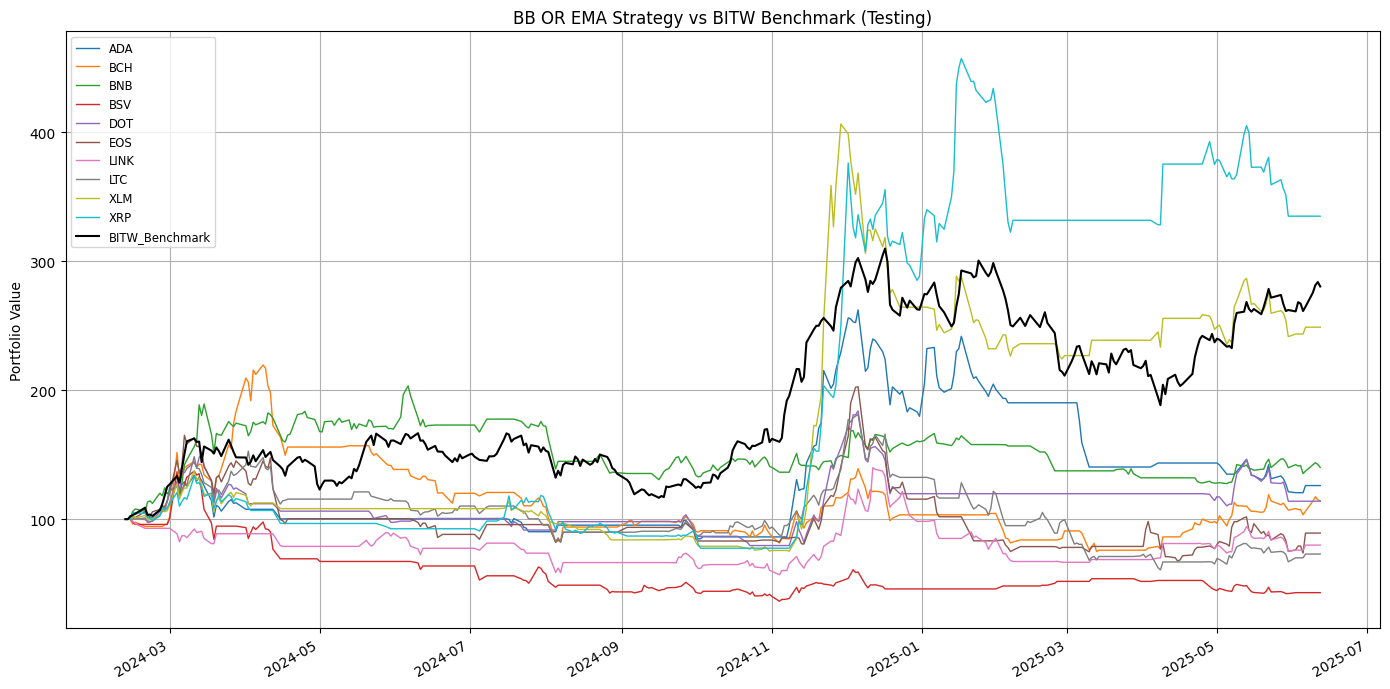

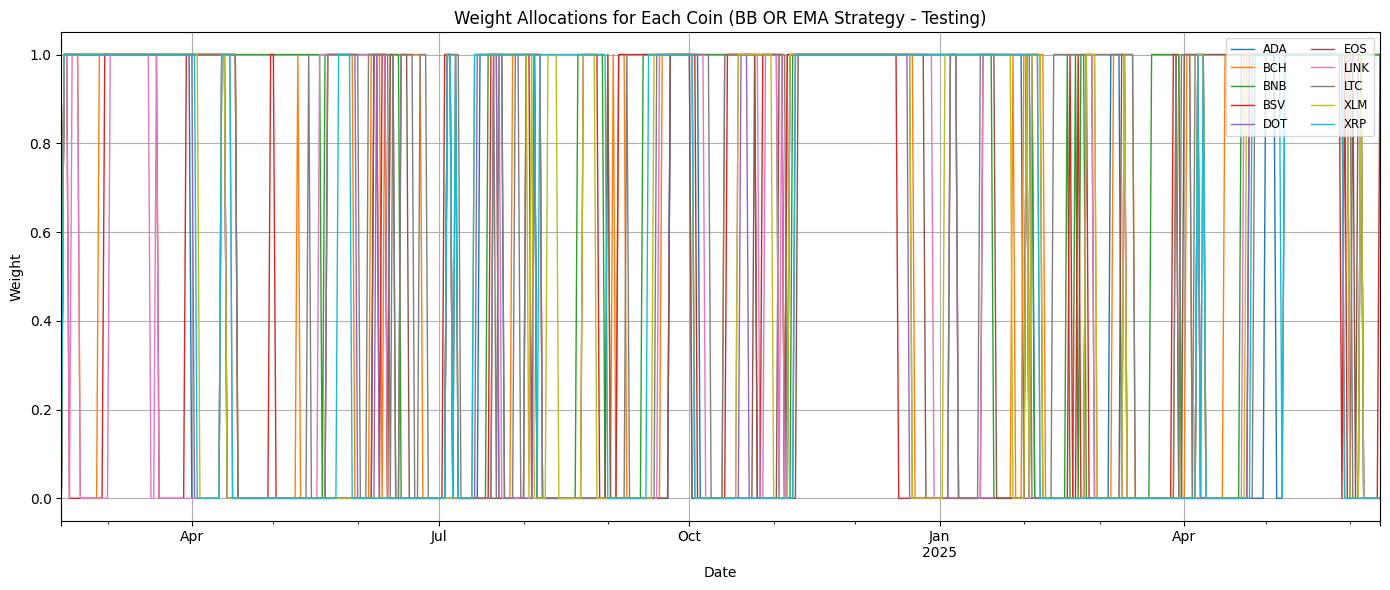

                      CAGR    Sharpe   Sortino  Max_Drawdown
Coin                                                        
ADA               0.190411  0.576621  1.066735     -0.540367
BCH               0.104425  0.488640  0.931604     -0.658474
BNB               0.288194  0.756784  1.306253     -0.372605
BSV              -0.469105 -0.598599 -0.940262     -0.734542
DOT               0.103233  0.452138  0.802382     -0.471820
EOS              -0.081816  0.277694  0.441239     -0.666621
LINK             -0.154917  0.092270  0.162375     -0.523995
LTC              -0.210490  0.017597  0.026774     -0.664577
XLM               0.984178  1.162411  3.147516     -0.451694
XRP               1.480346  1.494898  3.643517     -0.418586
BITW (Benchmark)  1.170520  1.648167  3.165085     -0.391944


In [11]:
# === Optimized Parameters (from Training) ===


# === Testing Dates ===
start_test = '2024-02-13'
end_test = '2025-06-13'
tickers = [f"{coin}-USD" for coin in optimized_params_or_strategy]

# === Download Data ===
price_data_test = yf.download(tickers, start=start_test, end=end_test)['Close']
price_data_test.columns = [col.replace('-USD', '') for col in price_data_test.columns]
price_data_test.dropna(axis=1, inplace=True)

# === Run Backtests ===
strategies_test = []
weights_dict_test = {}

for coin, (bb_window, std, threshold, ema_short, ema_long) in optimized_params_or_strategy.items():
    prices = price_data_test[[coin]].dropna()
    sma = prices[coin].rolling(bb_window).mean()
    std_dev = prices[coin].rolling(bb_window).std()
    lower_band = sma - std * std_dev
    ema_fast = prices[coin].ewm(span=ema_short, adjust=False).mean()
    ema_slow = prices[coin].ewm(span=ema_long, adjust=False).mean()

    bb_signal = (prices[coin] < (lower_band - threshold)).astype(float)
    ema_signal = (ema_fast > ema_slow).astype(float)
    combined_signal = ((bb_signal + ema_signal) >= 1).astype(float)

    weights = combined_signal.ffill().fillna(0)
    weights_df = pd.DataFrame(0.0, index=prices.index, columns=[coin])
    weights_df.loc[weights.index, coin] = weights.values
    weights_dict_test[coin] = weights_df

    strat = bt.Strategy(f"{coin}_BB_OR_EMA", [
        bt.algos.RunDaily(),
        bt.algos.SelectThese([coin]),
        bt.algos.WeighTarget(weights_df),
        bt.algos.Rebalance()
    ])
    strategies_test.append(bt.Backtest(strat, prices))

# === Benchmark ===
bitw_df_test = yf.download("BITW", start=start_test, end=end_test)[['Close']].dropna()
bitw_df_test.columns = ['BITW']
benchmark_test = bt.Strategy("BITW_Benchmark", [
    bt.algos.RunMonthly(),
    bt.algos.SelectAll(),
    bt.algos.WeighEqually(),
    bt.algos.Rebalance()
])
benchmark_bt_test = bt.Backtest(benchmark_test, bitw_df_test)

# === Run All Backtests ===
results_test = bt.run(*strategies_test, benchmark_bt_test)

# === Plot 1: Equity Curve ===
plt.figure(figsize=(14, 7))
for name in results_test.keys():
    color = 'black' if name == 'BITW_Benchmark' else None
    results_test[name].prices.plot(label=name.replace('_BB_OR_EMA', ''), linewidth=1.5 if name == 'BITW_Benchmark' else 1, color=color)
plt.title('BB OR EMA Strategy vs BITW Benchmark (Testing)')
plt.ylabel('Portfolio Value')
plt.grid(True)
plt.legend(loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

# === Plot 2: Weight Allocation Chart ===
weights_all_test = pd.concat(weights_dict_test.values(), axis=1)
weights_all_test.plot(figsize=(14, 6), linewidth=1)
plt.title('Weight Allocations for Each Coin (BB OR EMA Strategy - Testing)')
plt.ylabel('Weight')
plt.xlabel('Date')
plt.grid(True)
plt.legend(loc='upper right', fontsize='small', ncol=2)
plt.tight_layout()
plt.show()

# === Summary Stats Table ===
summary_test = []
for name in results_test.keys():
    stats = results_test[name].stats
    summary_test.append({
        'Coin': name.replace('_BB_OR_EMA', '') if name != 'BITW_Benchmark' else 'BITW (Benchmark)',
        'CAGR': stats.loc['cagr'],
        'Sharpe': stats.loc['daily_sharpe'],
        'Sortino': stats.loc['daily_sortino'],
        'Max_Drawdown': stats.loc['max_drawdown']
    })
df_summary_test = pd.DataFrame(summary_test).set_index('Coin')
print(df_summary_test)

# **EMA + BB Random Forest**

## **Macro Parameter Selection: XRP + XLM**

In [12]:
# Run a parameter loop on the train to see the best parameters for the recalls of the classes

# === Download Training Price Data Only ===
win_tickers = ['XLM-USD', 'XRP-USD']
start_date = '2021-01-01'
end_date = '2024-02-12'
data = yf.download(win_tickers, start=start_date, end=end_date)['Close']
data.columns = ['XLM', 'XRP']
data.dropna(inplace=True)

# === Strategy Parameters for Feature Engineering ===
params = {
    'XLM': (20, 1.5, 0.005, 10, 30),
    'XRP': (25, 2.0, 0.010, 10, 30)
}

frames = []
for coin, (bb_window, std, threshold, ema_short, ema_long) in params.items():
    price = data[coin]
    sma = price.rolling(bb_window).mean()
    std_dev = price.rolling(bb_window).std()
    lower_bb = sma - std * std_dev
    ema_fast = price.ewm(span=ema_short, adjust=False).mean()
    ema_slow = price.ewm(span=ema_long, adjust=False).mean()

    bb_signal = (price < (lower_bb - threshold)).astype(int)
    ema_signal = (ema_fast > ema_slow).astype(int)
    combined_signal = ((bb_signal + ema_signal) >= 1).astype(int)
    future_ret = price.pct_change(5).shift(-5)
    label = pd.qcut(future_ret, q=3, labels=[0, 1, 2])

    df = pd.DataFrame({
        'Price': price,
        'BB_Signal': bb_signal,
        'EMA_Signal': ema_signal,
        'Combined_Signal': combined_signal,
        'Target': label
    }).dropna()
    frames.append(df)

df_all = pd.concat(frames)

# === Prepare Training Data ===
X_train = df_all[['BB_Signal', 'EMA_Signal', 'Combined_Signal']]
y_train = df_all['Target'].astype(int)

# === Hyperparameter Tuning for Best Recall ===
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, recall_score

rf = RandomForestClassifier(random_state=42)
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

def recall_for_class(class_label):
    def score_func(y_true, y_pred):
        recalls = recall_score(y_true, y_pred, average=None, labels=[0, 1, 2])
        return recalls[class_label]
    return make_scorer(score_func)

scorers = {
    'recall_class_0': recall_for_class(0),
    'recall_class_1': recall_for_class(1),
    'recall_class_2': recall_for_class(2),
    'macro_recall': make_scorer(recall_score, average='macro')
}

results = {}
for label, scorer in scorers.items():
    search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_dist,
        n_iter=20,
        cv=3,
        verbose=0,
        scoring=scorer,
        n_jobs=-1,
        random_state=42
    )
    search.fit(X_train, y_train)
    results[label] = {
        'best_score': search.best_score_,
        'best_params': search.best_params_
    }

# Display as DataFrame
recall_results_df = pd.DataFrame(results).T
recall_results_df


/tmp/ipython-input-12-548553941.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(win_tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  2 of 2 completed


,best_score,best_params
recall_class_0,0.43781,"{'n_estimators': 100, 'min_samples_split': 10,..."
recall_class_1,0.314198,"{'n_estimators': 100, 'min_samples_split': 10,..."
recall_class_2,0.185185,"{'n_estimators': 100, 'min_samples_split': 10,..."
macro_recall,0.312398,"{'n_estimators': 100, 'min_samples_split': 10,..."


## **XRP + XLM RF on Best Parameters**

/tmp/ipython-input-13-2969889013.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(win_tickers, start=start_train, end=end_test)['Close']
[*********************100%***********************]  2 of 2 completed
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning

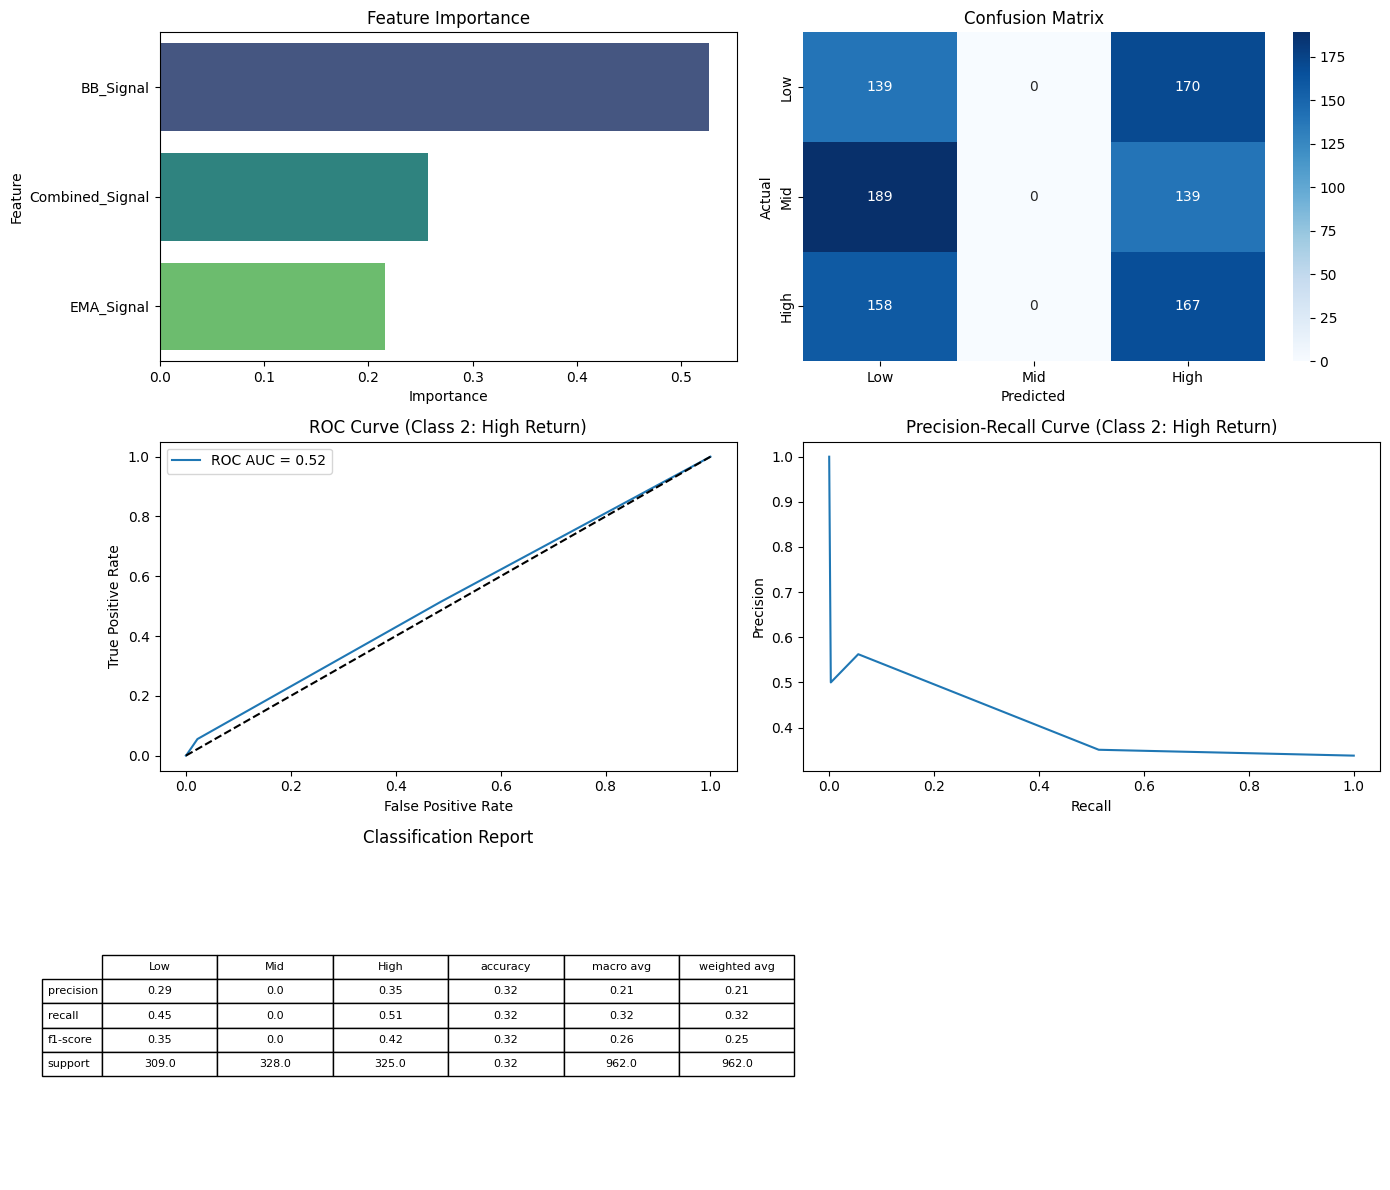

/tmp/ipython-input-13-2969889013.py:147: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bitw_df = yf.download("BITW", start=start_test, end=end_test)[['Close']].dropna()
[*********************100%***********************]  1 of 1 completed
100%|██████████| 3/3 [00:01<00:00,  2.45it/s]

                      CAGR    Sharpe   Sortino  Max_Drawdown
Coin                                                        
XLM               0.948731  1.138714  3.085646     -0.451694
XRP               1.418416  1.458912  3.556091     -0.418586
BITW (Benchmark)  1.097669  1.583590  3.039754     -0.391944


In [13]:
# This one
# Right TSS dates + bt strategies + BITW

# === Config ===
start_train = '2021-01-01'
end_train = '2024-02-12'
start_test = '2024-02-13'
end_test = '2025-06-13'

# === Download Historical Price Data ===
data = yf.download(win_tickers, start=start_train, end=end_test)['Close']
data.columns = ['XLM', 'XRP']
data.dropna(inplace=True)

# === Strategy Parameters ===
params = {
    'XLM': (20, 1.5, 0.005, 10, 30),
    'XRP': (25, 2.0, 0.010, 10, 30)
}

# === Feature Engineering & Labeling ===
frames = []
for coin, (bb_window, std, threshold, ema_short, ema_long) in params.items():
    price = data[coin]
    sma = price.rolling(bb_window).mean()
    std_dev = price.rolling(bb_window).std()
    lower_bb = sma - std * std_dev
    ema_fast = price.ewm(span=ema_short, adjust=False).mean()
    ema_slow = price.ewm(span=ema_long, adjust=False).mean()

    bb_signal = (price < (lower_bb - threshold)).astype(int)
    ema_signal = (ema_fast > ema_slow).astype(int)
    combined_signal = ((bb_signal + ema_signal) >= 1).astype(int)
    future_ret = price.pct_change(5).shift(-5)
    label = pd.qcut(future_ret, q=3, labels=[0, 1, 2])

    df = pd.DataFrame({
        'Price': price,
        'BB_Signal': bb_signal,
        'EMA_Signal': ema_signal,
        'Combined_Signal': combined_signal,
        'Target': label
    }).dropna()
    df['Coin'] = coin
    frames.append(df)

df_all = pd.concat(frames)

# === Date-Based Split ===
train_data = df_all[(df_all.index >= start_train) & (df_all.index <= end_train)]
test_data = df_all[(df_all.index >= start_test) & (df_all.index <= end_test)]

X_train = train_data[['BB_Signal', 'EMA_Signal', 'Combined_Signal']]
y_train = train_data['Target'].astype(int)
X_test = test_data[['BB_Signal', 'EMA_Signal', 'Combined_Signal']]
y_test = test_data['Target'].astype(int)

# === Train RF Using Best Macro Recall Parameters ===
best_model = RandomForestClassifier(
    n_estimators=100,
    min_samples_split=10,
    min_samples_leaf=4,
    max_depth=3,
    bootstrap=True,
    random_state=42
)
best_model.fit(X_train, y_train)

# === Predict on Test Set ===
test_data = test_data.copy()
test_data['Prediction'] = best_model.predict(X_test)
test_data['Signal'] = (test_data['Prediction'] == 2).astype(float)

# === Evaluation Metrics ===
report_df = pd.DataFrame(
    classification_report(y_test, test_data['Prediction'], output_dict=True, target_names=["Low", "Mid", "High"])
)
conf_matrix = confusion_matrix(y_test, test_data['Prediction'])
y_proba = best_model.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test == 2, y_proba[:, 2])
precision, recall, _ = precision_recall_curve(y_test == 2, y_proba[:, 2])
roc_auc = roc_auc_score(y_test == 2, y_proba[:, 2])
importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# === Charts ===
fig, axs = plt.subplots(3, 2, figsize=(14, 12))

sns.barplot(data=importances, x='Importance', y='Feature', ax=axs[0, 0], palette='viridis')
axs[0, 0].set_title('Feature Importance')

sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d',
            xticklabels=["Low", "Mid", "High"], yticklabels=["Low", "Mid", "High"], ax=axs[0, 1])
axs[0, 1].set_title("Confusion Matrix")
axs[0, 1].set_xlabel("Predicted")
axs[0, 1].set_ylabel("Actual")

axs[1, 0].plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
axs[1, 0].plot([0, 1], [0, 1], 'k--')
axs[1, 0].set_title("ROC Curve (Class 2: High Return)")
axs[1, 0].set_xlabel("False Positive Rate")
axs[1, 0].set_ylabel("True Positive Rate")
axs[1, 0].legend()

axs[1, 1].plot(recall, precision)
axs[1, 1].set_title("Precision-Recall Curve (Class 2: High Return)")
axs[1, 1].set_xlabel("Recall")
axs[1, 1].set_ylabel("Precision")

axs[2, 0].axis('off')
table = axs[2, 0].table(cellText=report_df.round(2).values,
                       colLabels=report_df.columns,
                       rowLabels=report_df.index,
                       cellLoc='center',
                       loc='center')
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1.2, 1.2)
axs[2, 0].set_title("Classification Report")

axs[2, 1].axis('off')
plt.tight_layout()
plt.show()

# === Backtest Preparation ===
strategies = []
for coin in test_data['Coin'].unique():
    df_coin = test_data[test_data['Coin'] == coin].copy()
    prices = df_coin[['Price']].copy()
    prices.columns = [coin]

    signal = df_coin[['Signal']].copy()
    signal.columns = [coin]
    signal = signal.reindex(prices.index).fillna(0)

    strategy = bt.Strategy(f"RF_{coin}", [
        bt.algos.RunDaily(),
        bt.algos.SelectThese([coin]),
        bt.algos.WeighTarget(signal),
        bt.algos.Rebalance()
    ])
    strategies.append(bt.Backtest(strategy, prices))

# === Benchmark ===
bitw_df = yf.download("BITW", start=start_test, end=end_test)[['Close']].dropna()
bitw_df.columns = ['BITW']
benchmark = bt.Strategy("BITW_Benchmark", [
    bt.algos.RunMonthly(),
    bt.algos.SelectAll(),
    bt.algos.WeighEqually(),
    bt.algos.Rebalance()
])
benchmark_bt = bt.Backtest(benchmark, bitw_df)

# === Run Backtests ===
results = bt.run(*strategies, benchmark_bt)

# === Summary Table ===
summary = []
for name in results.keys():
    stats = results[name].stats
    summary.append({
        'Coin': name.replace('RF_', '') if name != 'BITW_Benchmark' else 'BITW (Benchmark)',
        'CAGR': stats.loc['cagr'],
        'Sharpe': stats.loc['daily_sharpe'],
        'Sortino': stats.loc['daily_sortino'],
        'Max_Drawdown': stats.loc['max_drawdown']
    })
df_summary = pd.DataFrame(summary).set_index('Coin')
print(df_summary)


## **Signal Timeseries**

In [14]:
import plotly.graph_objects as go

# === Define Colors and Markers for Each Class ===
class_colors = {
    0: 'red',
    1: 'orange',
    2: 'green'
}
class_symbols = {
    0: 'triangle-down',
    1: 'circle',
    2: 'triangle-up'
}

# === Loop Over Each Coin and Plot Interactive Chart ===
for coin in test_data['Coin'].unique():
    df_plot = test_data[test_data['Coin'] == coin].copy()

    fig = go.Figure()

    # Add price line
    fig.add_trace(go.Scatter(
        x=df_plot.index,
        y=df_plot['Price'],
        mode='lines',
        name='Price',
        line=dict(color='blue', width=2),
        hovertemplate='Date: %{x|%Y-%m-%d}<br>Price: %{y:.4f}<extra></extra>'
    ))

    # Add predicted class markers
    for cls in [0, 1, 2]:
        class_df = df_plot[df_plot['Prediction'] == cls]
        fig.add_trace(go.Scatter(
            x=class_df.index,
            y=class_df['Price'],
            mode='markers',
            name=f'Class {cls}',
            marker=dict(
                symbol=class_symbols[cls],
                size=8,
                color=class_colors[cls]
            ),
            hovertemplate=f'Class {cls}<br>Date: %{{x|%Y-%m-%d}}<br>Price: %{{y:.4f}}<extra></extra>'
        ))

    # Layout and interactivity settings
    fig.update_layout(
        title=f"{coin} - RF Predicted Classes Over Time (Interactive)",
        xaxis_title="Date",
        yaxis_title="Price",
        template='plotly_white',
        hovermode='x unified',
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
        height=500
    )

    fig.show()
